In [1]:
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from hubmap.data import DATA_DIR

In [2]:
train_for_cal = TrainDataset(DATA_DIR, transform=tran.ToTensor())
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
count = len(train_for_cal) * 512 * 512
loader_for_cal = DataLoader(train_for_cal, batch_size=32, shuffle=False)


In [3]:
for inputs, mask in loader_for_cal:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [4]:
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

In [5]:
transforms_augment = tran.Compose([
    tran.ToTensor(mask_as_integer=True),
    tran.RandomHorizontalFlip(),
    tran.RandomVerticalFlip(),
    tran.Normalize(total_mean, total_std) 
])

transforms_val = tran.Compose([
    tran.ToTensor(mask_as_integer=True),
    tran.Normalize(total_mean, total_std) 
])

In [7]:
train = TrainDataset(DATA_DIR, transform=transforms_augment, with_background=True, as_id_mask=True)
#test = TestDataset('../data/', transform=transforms, with_background=True, as_id_mask=True)
val = ValDataset(DATA_DIR, transform=transforms_val, with_background=True, as_id_mask=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


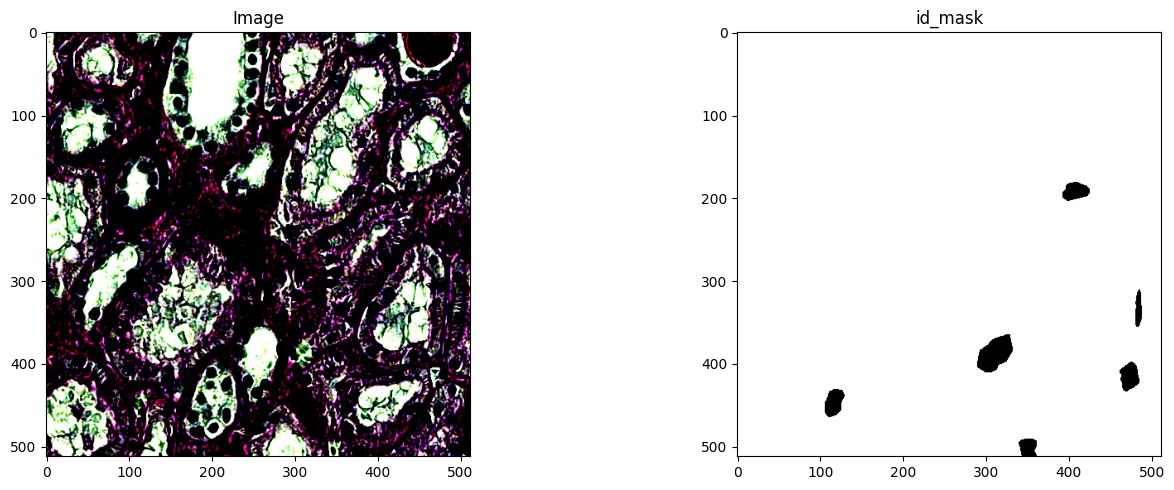

In [8]:
train.plot_example(4)

In [8]:
val.plot_example(10)

ValueError: std evaluated to zero after conversion to torch.float32, leading to division by zero.

In [9]:
batch_size = 2
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
from transformers import SegformerForSemanticSegmentation

ModuleNotFoundError: No module named 'transformers'

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b2", 
        num_labels=4,
    ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
num_epochs = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.squeeze(1).long().to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        #i only care about blood vessel accuracy
        mask = (labels == 0)

        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        running_loss += loss.item()

    train_accuracy.append(100 * correct / total if total != 0 else 0)
    train_loss.append(running_loss / i)

     # Testing
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        labels = labels.squeeze(1).long().to(device)
        inputs = inputs.to(device)
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss

        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels == 0)
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        running_loss += loss.item()
    
    test_accuracy.append(100 * correct / total if total != 0 else 0)
    test_loss.append(running_loss / i)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Train Acc: {train_accuracy[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_accuracy[-1]}")


Epoch 1, Train Loss: 0.38467205418091194, Train Acc: 4.372290526373361, Test Loss: 0.28138838104965275, Test Acc: 13.437025635623698
Epoch 2, Train Loss: 0.3052994632983909, Train Acc: 18.294713845007998, Test Loss: 0.20963690469949697, Test Acc: 20.66481565478104
Epoch 3, Train Loss: 0.24756643799395342, Train Acc: 25.024198552045696, Test Loss: 0.3092722490368303, Test Acc: 17.045044520975996
Epoch 4, Train Loss: 0.2368351439001903, Train Acc: 27.966131118818918, Test Loss: 0.16937170105347457, Test Acc: 30.063548613038158
Epoch 5, Train Loss: 0.22152154453804876, Train Acc: 29.386667197372777, Test Loss: 0.2072279740833054, Test Acc: 27.45274141830379
Epoch 6, Train Loss: 0.19766220225179507, Train Acc: 32.378604020055825, Test Loss: 0.15684241324293713, Test Acc: 28.14183981253002
Epoch 7, Train Loss: 0.19005382953978636, Train Acc: 33.318540855052014, Test Loss: 0.19468117428343157, Test Acc: 30.41147805552564
Epoch 8, Train Loss: 0.195492269331285, Train Acc: 34.10972487207394, T

In [16]:
from skimage.color import label2rgb
import torchvision.transforms as T
import numpy as np

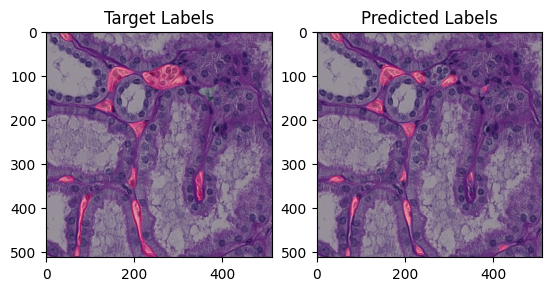

In [40]:
image, target = val.get(5, transform=tran.ToTensor(mask_as_integer=True))
input, mask = val.get(5, transform=val.transform)
input = input.unsqueeze(0).to(device)
mask = mask.to(device).long()
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=input, labels=mask.long())
    
upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
predicted = upsampled_logits.argmax(dim=1)



toPILImage = T.ToPILImage()
imagePIL = toPILImage(image)
image_np = np.array(imagePIL)

targetPIL = toPILImage(target.byte())
target_np = np.array(targetPIL)

predictedPIL = toPILImage(predicted.byte())
predicted_np = np.array(predictedPIL)

image_label_overlay = label2rgb(
    target_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)


image_predicted_overlay = label2rgb(
    predicted_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image_label_overlay)
ax[0].set_title('Target Labels')

ax[1].imshow(image_predicted_overlay)
ax[1].set_title('Predicted Labels')

plt.show()



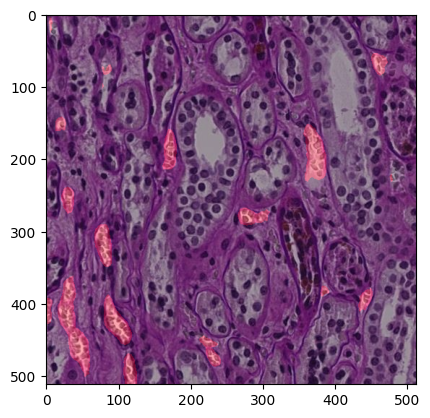

In [31]:
image_label_overlay = label2rgb(
    predicted_np,
    image=image_np,
    bg_label=3,
    colors=["red", "green", "blue"],
    kind="overlay",
    saturation=1.0,
)


plt.imshow(image_label_overlay)